In [1]:
from nn_models import SEIR_PINN
from BNN import BNN
import matplotlib.pyplot as plt
import numpy as np
from epidemic_model import SEIR_Model, Epidemic_Model
from utils.utils import load_data, parser
import sys
import torch

Loaded data from file ./data/Smoothed_Cases_Third_Wave.csv


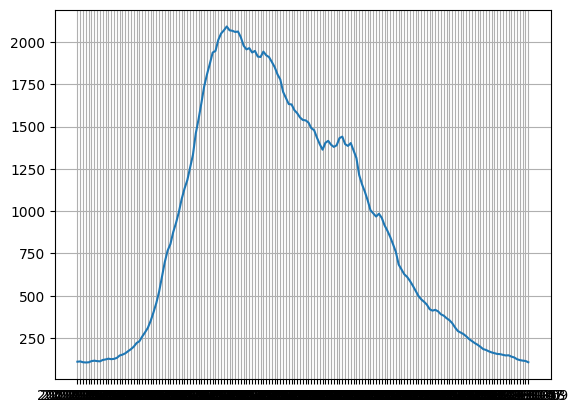

In [2]:
args = ['configuration_file_bnn.cfg']

fname_conf = args[0]
params = parser(fname_conf)

times, data, dates = load_data(params['fname'])

print(f'Loaded data from file {params["fname"]}')

plt.figure()
plt.plot(dates,data)
plt.grid()
plt.show()

In [3]:

N = params["N"]
print(f'Data willl be normalized by factor {N}')

E0 = 0 
I0 = data[0]
R0 = 0
S0 = 1 - E0 - I0 - R0

x0 = [S0,E0,I0,R0]

beta = params['beta_0']
sigma = params['sigma_0']
gamma = params['gamma_0']

n_iterations = params['iterations']
sampler = params['sampler']
lambda_data = params['lambda_data']
lambda_cond = params['lambda_cond']
lambda_eq = params['lambda_eq']
sigma = params['sigma']
bounds = [[params['beta_min'], params['beta_max']], 
    [params['sigma_min'], params['sigma_max']], 
    [params['gamma_min'], params['gamma_max']]]
likelihood = params['likelihood_model']


Data willl be normalized by factor 2500000


In [4]:
model = BNN(SEIR_PINN,1,3,params['n_hidden'],params['n_flayers'])

model.model.log_beta = torch.nn.Parameter(torch.log(torch.tensor(beta, dtype=torch.float32)), requires_grad=True)
model.model.log_sigma = torch.nn.Parameter(torch.log(torch.tensor(sigma, dtype=torch.float32)), requires_grad=True)
model.model.log_gamma = torch.nn.Parameter(torch.log(torch.tensor(gamma, dtype=torch.float32)), requires_grad=True)


In [5]:

model.infer_parameters(n_iterations, 
                       #sampler=sampler,
                       params=[model.model.log_beta,model.model.log_sigma,model.model.log_gamma],
                       data=data,
                       t=times,
                       #lambda_data=lambda_data,
                       #lambda_cond=lambda_cond,
                       #lambda_eq=lambda_eq,
                       #sigma=sigma,
                       bounds=bounds,
                       S0=S0,
                       E0=E0,
                       I0=I0,
                       R0=R0,
                       likelihood=likelihood,
                       **params
                       )

Running on sampler: emcee
using 722 walkers


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
beta_sample = [np.exp(_) for _ in model.Output[:,:,-3].flatten()]
sigma_sample = [np.exp(_) for _ in model.Output[:,:,-2].flatten()]
gamma_sample = [np.exp(_) for _ in model.Output[:,:,-1].flatten()]



beta_mean = np.mean(beta_sample)
sigma_mean = np.mean(sigma_sample)
gamma_mean = np.mean(gamma_sample)

print(beta_mean, sigma_mean, gamma_mean)

In [ ]:

plt.figure()
plt.plot(times, data, 'ko', label='Datos')

for beta_i, sigma_i, gamma_i in zip(beta_sample[-50:], sigma_sample[-50:], gamma_sample[-50:]) :
    
    seir = SEIR_Model((beta_i), (sigma_i), (gamma_i), 1)
    print(beta_i, sigma_i, gamma_i)
    x = seir.run(x0, times)
    incidency = -seir.incidency(np.hstack([[1],x[0]]),times,1)    
    plt.plot(times, incidency, 'g', alpha=0.2, lw=3)

seir = SEIR_Model(beta_mean, sigma_mean, gamma_mean, 1)

x = seir.run(x0, times)
incidency = -seir.incidency(np.hstack([[1],x[0]]),times,1)    

plt.plot(times, incidency, 'r--', lw=3)
    
plt.grid()
#plt.ylim(0,1)
plt.show()


In [ ]:

plt.figure()
plt.plot(times, data, 'ko', label='Datos')

with torch.no_grad() :
    original_prediction = model.model.forward(torch.tensor(times,dtype=torch.float32).view(-1,1))
    
    S_pred, E_pred, I_pred = torch.split(original_prediction,1,dim=1)
    S_numpy = S_pred.detach().numpy().reshape(-1)
    E_numpy = E_pred.detach().numpy().reshape(-1)
    I_numpy = I_pred.detach().numpy().reshape(-1)
    base_model = Epidemic_Model()
    incidency =  -base_model.incidency(np.hstack([[1],S_numpy]),times,1)

plt.plot(times, incidency, color='steelblue', label='Inicial')

for i in range(0,n_iterations,10) :
    
    for j in range(0,model.nwalkers,100) :
        w_i = model.Output[i,j]
        weights = w_i[:-model.nparams]
        beta_i, sigma_i, gamma_i = w_i[-model.nparams:]

        model.set_weights(weights)
        with torch.no_grad() :
            prediction = model.model.forward(torch.tensor(times,dtype=torch.float32).view(-1,1)).T

        S = prediction[0].detach().numpy().reshape(-1)
            
        base_model = Epidemic_Model()
        incidency =  -base_model.incidency(np.hstack([[1],S]),times,1)
        
        plt.plot(times,incidency,'steelblue',alpha=0.2)

        seir = SEIR_Model(np.exp(beta_i), np.exp(sigma_i), np.exp(gamma_i), 1)
        
        x = seir.run(x0, times)
            
        plt.plot(times, x[2,:], 'g', alpha=0.2, lw=3)
        
        
plt.grid()
#plt.ylim(0,1)
plt.show()
